<a id='ImpPkg'></a>
# 1. Import Packages

In [1]:
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame as DF

import seaborn as sns
sns.set(color_codes=True)
#np.random.seed(sum(map(ord, "distributions")))
from sklearn import linear_model  # packages for the logistic regression function to plot the logistic regression 
from sklearn.linear_model import LogisticRegression # packages for the logistic regression function to plot the logistic regression 
import scipy
from scipy import stats, integrate
from scipy.stats import mode
from scipy.stats.stats import pearsonr # Pearson's correlation
from copy import copy as copy
import operator as operator
import pylab

# Plotting tools
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%pylab inline
figsize(5, 5)

import glob

import os
# Added to avoid OMP:error#15
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pylab', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import rpy2

%load_ext rpy2.ipython
# Set up interface with R
# Make it easy to set and find values in a multi-index DF
idx = pd.IndexSlice
# Set up interface with R
%config InlineBackend.figure_format = 'retina'
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)


In [3]:
def Coefpresplot_bar2(regtable1, mixtable1,regtable2, mixtable2, intercept=False, barcol1='#000000',barcol2='#000000', title='Regression Coefficients', size='big', ylimits=(), ymultiple=0.5, ticklabsize=25, n_ET_predictors = 0 ):

    # Import itertools so that we can iterate through the colours
    import itertools
    
    # Import locators so that we can tidy up the yaxis
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    
    # rounding function to get edges to even 0.5 values
    def round_to(n, precision):
        correction = 0.5 if n >= 0 else -0.5
        return int( n/precision+correction ) * precision

    def round_to_5(n):
        return round_to(n, 0.5)
            
    # Set seaborn style for the plot
    sns.set(style='white')
    
    bar_sep= 0.25
    
    # Generate the figure
    if size=='big':
        fig = plt.figure(figsize=[20,8])
    elif size=='long':
        fig = plt.figure(figsize=[20,4])
    elif size=='narrow':
        fig = plt.figure(figsize=[10,4])
        
    fig.suptitle(title, fontsize=20)
    gs = GridSpec(1,1,bottom=0.18,left=0.18,right=0.82)
    ax = fig.add_subplot(gs[0,0])
    
    # Set axis limits based on whether to include the intercept or not   
    # Assumuing that regtable1 and regtable2 have exactly the same number of coefficients
    if intercept == True:
        XLim = (0, len(regtable1.columns) + 2)
        YLim = (round_to_5(np.min([mixtable1,mixtable2]))-0.2, round_to_5(np.max([mixtable1,mixtable2]))+0.2)
    else:
        XLim = (0, len(regtable1.columns) +1)
        YLim = (round_to_5(np.min([mixtable1,mixtable2]))-0.2, round_to_5(np.max([mixtable1,mixtable2]))+0.2)
    if ylimits != ():
        YLim = ylimits
    ax.set_xlim(XLim)
    ax.set_ylim(YLim)
    
    # Draw a line through the 0-value on the y-axis
    line = ax.plot(XLim, [0, 0], color='black', ls='--', alpha = 0.5, lw=3)
    
    
    # If intercept is true, plot the coefficient for the intercept
    # Assumuing that regtable1 and regtable2 have exactly the same number of coefficients

    if intercept == True:
        Coefficients = regtable1.columns
    else:
        if len(regtable1.columns)<len(mixtable1):
            Coefficients = regtable1.columns
        else:
            Coefficients = regtable1.columns[1:]
        
    # Determine the colours for the coefficients based on the n_ET_variable
    n_predictors = len(Coefficients)
    n_non_ET_predictors = n_predictors - n_ET_predictors
    
    # Color for conditions 1 and 2
    colourlist1 = [barcol1] * n_non_ET_predictors + ['#03719c'] * n_ET_predictors
    colourlist2 = [barcol2] * n_non_ET_predictors + ['#03719c'] * n_ET_predictors
    
        
    # Plot all the coefficients with 95% CI
    position = 0
    for Coefficient in Coefficients:
        position += 1
        # Plot condition 1
        ax.bar(position-bar_sep, regtable1.loc['coefficient', Coefficient], width=0.4,color=colourlist1[position-1],)
        ax.errorbar(position-bar_sep, regtable1.loc['coefficient', Coefficient],
                    yerr=regtable1.loc['se', Coefficient]*1.96, lw=2, color='#000000')

        # Plot condition 2
        ax.bar(position+bar_sep, regtable2.loc['coefficient', Coefficient], width=0.4,color=colourlist2[position-1],)
        ax.errorbar(position+bar_sep, regtable2.loc['coefficient', Coefficient],
                    yerr=regtable2.loc['se', Coefficient]*1.96, lw=2, color='#000000')

        
   # Plot dots for the individual coefficients
    # Assumuing that mixtable1 and mixtable2 have exactly the same number of elements 
    
    if intercept == True:
        coef_num = range(0,len(mixtable1)) 
    else:
        coef_num = range(1,len(mixtable1))
        
    for i in coef_num:
        # Plot dots condition 1
        part_coefs = mixtable1[i]
        position_parts= np.full(len(part_coefs), i, dtype=int)
        jittr = np.random.uniform(low=-0.2,high=0.2,size=len(part_coefs))/2
        ax.plot(position_parts-bar_sep+jittr, part_coefs, marker='o', ms=8, color='#000000',alpha=0.3,linestyle="None")

        # Plot dots condition 1
        part_coefs = mixtable2[i]
        position_parts= np.full(len(part_coefs), i, dtype=int)
        jittr = np.random.uniform(low=-0.2,high=0.2,size=len(part_coefs))/2
        ax.plot(position_parts+bar_sep+jittr, part_coefs, marker='o', ms=8, color='#000000',alpha=0.3,linestyle="None")
        

    # Setting the x-axis major tick's location
    ax.set_xticks(range(1, position+1))
    
    # set the y-axis major tick position
    ax.yaxis.set_major_locator(MultipleLocator(ymultiple))


    # Setting the x-axis major tick's label
    if intercept == True:
        ax.set_xticklabels(regtable1.columns, rotation=0)        
    else:
        if len(regtable1.columns)<len(mixtable1):
            ax.set_xticklabels(regtable1.columns, rotation=0)
        else:    
            ax.set_xticklabels(regtable1.columns[1:], rotation=0)
    
    ax.tick_params(axis='both', which='major', labelsize=ticklabsize)
    ax.set_ylabel('Regression Coefficients', fontsize=18)
    
    # Autoformats the ticklabels for the xaxis
    fig.autofmt_xdate()
    
    sns.despine()

In [4]:
def regtable(fix, fix_se, names):
    fixed_betas = DF(np.array(fix)); fixed_betas = fixed_betas.transpose(); fixed_betas.columns = names
    fixed_betas.loc[1] = np.array(fix_se)
    fixed_betas.loc[2] = fixed_betas.loc[0] - (fixed_betas.loc[1]*1.96)
    fixed_betas.loc[3] = fixed_betas.loc[0] + (fixed_betas.loc[1]*1.96)
    fixed_betas.index = ['coefficient', 'se', 'CImin', 'CImax']
    return fixed_betas

In [5]:
def ttestprint (Choice_Like_hmodel_table,Choice_Dislike_hmodel_table, mix_Choice_Like_model,mix_Choice_Dislike_model):

    if len(Choice_Like_hmodel_table.columns) >= len(mix_Choice_Like_model):
        print ("Mismatch")
    
    
    print ("---------------- SIGNIFICANT FACTOR ----------------------")
    
    for i in range(len(Choice_Like_hmodel_table.columns)):
        param_name = Choice_Like_hmodel_table.columns[i]
        part_coefs_like = mix_Choice_Like_model[ i ]
    
        [s, p] = stats.ttest_1samp(part_coefs_like,0)
        if p<0.01:
            print (param_name + " : MeanL = "+ str(round(mean(part_coefs_like),2))+ "; t =  " + str(round(s,2)) + " ; p-value =" + str(round(p,2))+ "**")
        elif p<0.05:
            print (param_name + " : MeanL = "+ str(round(mean(part_coefs_like),2))+ "; t =  " + str(round(s,2)) + " ; p-value =" + str(round(p,2))+ "*")
        else:
            print (param_name + " : MeanL = "+ str(round(mean(part_coefs_like),2))+ "; t =  " + str(round(s,2)) + " ; p-value =" + str(round(p,2)))
    
      
        part_coefs_dislike = mix_Choice_Dislike_model[ i ]
    
        [s, p] = stats.ttest_1samp(part_coefs_dislike,0)
        
        if p<0.01:
            print (param_name + " : MeanD = "+ str(round(mean(part_coefs_dislike),2))+ "; t =  " + str(round(s,2)) + " ; p-value =" + str(round(p,2)) + "**")
        elif p<0.05:
            print (param_name + " : MeanD = "+ str(round(mean(part_coefs_dislike),2))+ "; t =  " + str(round(s,2)) + " ; p-value =" + str(round(p,2)) + "*")
        else:
            print (param_name + " : MeanD = "+ str(round(mean(part_coefs_dislike),2))+ "; t =  " + str(round(s,2)) + " ; p-value =" + str(round(p,2)))
        
        
    print ("---------------- COMPARE [ LIKE - DISLIKE ] ----------------------")
    
    for i in range(len(Choice_Like_hmodel_table.columns)):
        param_name = Choice_Like_hmodel_table.columns[i]
        part_coefs_like = mix_Choice_Like_model[ i ]
        part_coefs_dislike = mix_Choice_Dislike_model[ i ]
                
        diff = mean(part_coefs_like) - mean(part_coefs_dislike)
        [s, p] = stats.ttest_rel(part_coefs_like,part_coefs_dislike)
        
        if p<0.01:
            print (param_name + " : MeanL = "+ str(round(mean(part_coefs_like),2))+ "; MeanD = "+ str(round(mean(part_coefs_dislike),2))+"; [Like - Dislike] =  " + str(round(diff)) +"; t =  " + str(round(s,2)) + " ; p-value =" + str(round(p,2))+ "**" )
        elif p<0.05:
            print (param_name + " : MeanL = "+ str(round(mean(part_coefs_like),2))+ "; MeanD = "+ str(round(mean(part_coefs_dislike),2))+"; [Like - Dislike] =  " + str(round(diff)) +"; t =  " + str(round(s,2)) + " ; p-value =" + str(round(p,2))+ "*" )
        else:
            print (param_name + " : MeanL = "+ str(round(mean(part_coefs_like),2))+ "; MeanD = "+ str(round(mean(part_coefs_dislike),2))+"; [Like - Dislike] =  " + str(round(diff)) +"; t =  " + str(round(s,2)) + " ; p-value =" + str(round(p,2)) )
        
    

In [6]:
def z_score1(data_all, part_def,z_score_var):
    z_matrix=[]
    z_matrix_aux=[]

    for i in (data_all[part_def].unique()):
        Choicedata = data_all.loc[data_all[part_def] == i]    
    
        pX_A= pd.to_numeric(Choicedata[z_score_var]) 
        pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)

        z_matrix_aux= pX_zA.values
    
        for  j in range(len(z_matrix_aux)):    
            z_matrix.append(z_matrix_aux[j])
    return z_matrix

In [7]:
def splitBy(data_exp1, Splits_headers = ['ConfSplit', 'GSFMedSplit','DDTMedSplit'],Splits_variables = ['Conf', 'tGSF','tDDT']):
    
    median_matrix=[]
    median_matrix_aux=[]
    median_matrix_aux_cond=[]
    Split_cols = []
    
    for h in range(len(Splits_variables)):
        median_matrix=[]
        for i in unique(data_exp1["Part"]):
            median_matrix_aux=[]
    
            for j in unique(data_exp1["BlockCond"]):
                #median_matrix_aux_cond=[]
    
                #Extract data by participant and BlockCond (1: Like, 2: Dislike)
                Splitdata = data_exp1.loc[data_exp1['Part'] == i]
                Splitdata = Splitdata.loc[Splitdata['BlockCond'] == j]
                
                # Select the column to split
                Splitdata = Splitdata.loc[:,['TrialN',Splits_variables[h]]]
                SplitSort = Splitdata.values
                # Sort for confidence column
                SplitSort = SplitSort[np.argsort(SplitSort[:, 1])]
                #print(SplitSort)
                lenPart = len(Splitdata)
                #print(lenPart)
                # Generate column with median order
                median_low = [0] * int (lenPart/2)
    
                if len(SplitSort) != 2*len(median_low):
                    median_high=  [1] * int(len(SplitSort)-len(median_low))
                else: median_high = [1] * int (lenPart/2)
            
                median_split_order = median_low + median_high
                #Attach split median order column (1 and 0)
                median_aux= np.column_stack((SplitSort,median_split_order))
                #Sort back to trial number
                SplitSorted = median_aux[np.argsort(median_aux[:, 0])]
                #print(len(SplitSorted))
                
                for kk in range(len(SplitSorted)): 
                    if len(median_matrix_aux) == 0 :
                        median_matrix_aux = SplitSorted[0]
                    else:
                        median_matrix_aux = np.vstack([median_matrix_aux, SplitSorted[kk]])
            
            
            #print(["participant "+ str(i)+ " done"])
            # sort after adding both conditions    
            median_matrix_aux = median_matrix_aux[np.argsort(median_matrix_aux[:, 0])]
            
            #Extract only the column with the median split information
            median_matrix_aux = median_matrix_aux[:,2]
            
            #append to median matrix for the participants
            for k in range(len(median_matrix_aux)):    
                median_matrix.append(median_matrix_aux [k])
        
        median_matrix = pd.DataFrame(median_matrix,columns=[Splits_headers[h]])
        #print(len (median_matrix))
        #add new column (new split variable columns) to the split matrix
        if  h == 0:
            Split_cols = median_matrix
        else:
            Split_cols = pd.concat([Split_cols,median_matrix ],axis =1)   
    
    return Split_cols

## LOAD

In [8]:
# Load data all participants
#data_exp1 = pd.read_csv('/Users/pradyumna/Documents/gitDocs/FF2018/Output/DataFoodFramingNotebook_v1.csv') 
#data_exp1 = pd.read_csv('/Users/pradyumna/Documents/GiTs/PF2019/Data/DataPerceptFramingNotebook_P21to62.csv') 

data_exp1 = pd.read_csv('/Users/pradyumna/Documents/GiTs/PF2019/Data/DataPerceptualFramingNotebook_v1.csv') 


for i in []:
    data_exp1 = data_exp1[(data_exp1.Part != i)]
print (data_exp1["Part"].unique())
print ('Number of participants: ' + str(len(data_exp1["Part"].unique())))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
Number of participants: 33


In [9]:
data_exp1=data_exp1.rename(index=str, columns={"ChosenITM":"Choice", 
                              "ChoiceRT":"RT",
                             "RValue":"RVal",
                             "LValue":"LVal",
                             "zRValue":"zRVal",
                             "zLValue":"zLVal",                    
                             "tDDT":"DDT",
                             "absDDT":"zAbsDDT",
                             "lIA_DT":"LDwellTime",
                             "rIA_DT":"RDwellTime",
                             "tGSF":"GSF",
                             "lastFixat":"LastFixat",
                             "DV":"DVal",
                             "zDV":"zDVal",
                             "absDV":"AbsDVal",
                             "zAbsDV":"zAbsDVal",                    
                             "zChoiceRT":"zRT",
                             "FamCh":"ChosenFam",
                              "FamUnCh":"UnchosenFam",
                              "ValCh":"ChosenVal",
                              "ValUnCh":"UnchosenVal",
                             "zFamCh":"zChosenFam",
                              "zFamUnCh":"zUnchosenFam",
                              "zValCh":"zChosenVal",
                              "zValUnCh":"zUnchosenVal",                   
                              "GSFMedSplit":"GSFSplit",
                            "DDTMedSplit":"DDTSplit"})


## Add missing zScored values

In [10]:
data_exp1["zGSF"] = z_score1(data_exp1,'Part',"GSF")
data_exp1["zDDT"] = z_score1(data_exp1,'Part',"DDT")
data_exp1["AbsDDT"] = abs(data_exp1["DDT"])
data_exp1["zAbsDDT"] = z_score1(data_exp1,'Part',"AbsDDT")

data_exp1["TotVal"] = data_exp1['LVal']+ data_exp1['RVal']
data_exp1["zTotVal"] = z_score1(data_exp1,'Part',"TotVal")

data_exp1["ChosenVal"] = data_exp1['RVal']*data_exp1['Choice']+ data_exp1['LVal']*(1-data_exp1['Choice'])
data_exp1["UnchosenVal"] = data_exp1['LVal']*data_exp1['Choice']+ data_exp1['RVal']*(1-data_exp1['Choice'])
data_exp1["zChosenVal"] = z_score1(data_exp1,'Part',"ChosenVal")
data_exp1["zUnchosenVal"] = z_score1(data_exp1,'Part',"UnchosenVal")


## Change the name of the BlockCond

In [11]:
# Change so everything is equal
data_exp1 = data_exp1.replace('NEXTLESS', 'MORE')
data_exp1 = data_exp1.replace('NEXTMORE', 'LESS')
data_exp1['BlockCond'].unique()

# Change so everything is equal
data_exp1 = data_exp1.replace('MORE', 1)
data_exp1 = data_exp1.replace('LESS', 2)
data_exp1['BlockCond'].unique()

array([2, 1])

## Add correct variable

In [12]:
Correct = []
for i in range(len(data_exp1)):
    if data_exp1.BlockCond[i] == 1:
        if (data_exp1.Choice[i] == 1 and (data_exp1.LVal[i] < data_exp1.RVal[i])) or (data_exp1.Choice[i] == 0 and (data_exp1.LVal[i] > data_exp1.RVal[i])):
            Correct.append(1)
        else:
            Correct.append(0)
    if data_exp1.BlockCond[i] == 2:
        if (data_exp1.Choice[i] == 1 and (data_exp1.LVal[i] > data_exp1.RVal[i])) or (data_exp1.Choice[i] == 0 and (data_exp1.LVal[i] < data_exp1.RVal[i])):
            Correct.append(1)
        else:
            Correct.append(0)

data_exp1["Correct"] = Correct

## Add Splits variable

In [13]:
data_splits = splitBy(data_exp1, Splits_headers = ['ConfSplit', 'GSFMedSplit','DDTMedSplit'],Splits_variables = ['Conf', 'GSF','DDT'])
#data_exp11 = splitBy(data_exp1.loc[data_exp1['Part'] == 1], ['ConfSplit'], ['Conf'])


In [14]:
data_exp1['ConfSplit'] = data_splits['ConfSplit'].values
data_exp1['GSFSplit'] = data_splits['GSFMedSplit'].values
data_exp1['DDTSplit'] = data_splits['DDTMedSplit'].values

## Load data to R

In [67]:
%R -i data_exp1


/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [68]:
%%R
library(lme4)
library(car)
library(optimx)
library(ggplot2)
library(MASS)
library(broom)
library(dplyr)
library(reshape2)
library(arm)
library(multcomp)
library(pbkrtest)

In [69]:
%R
##Change Column name for better regression presentation
#colnames(data_exp1)[which(names(data_exp1) == "zChoiceRT")] <- "zRT"
#colnames(data_exp1)[which(names(data_exp1) == "ChoiceRT")] <- "RT"

In [70]:
%%R
# Separating the data for both conditions 
data_exp1_Like <- data_exp1[ which(data_exp1$BlockCond=='1'), ]
data_exp1_DisLike <- data_exp1[ which(data_exp1$BlockCond=='2'), ]

# Regression

## Choice ~ BehavioralParams + DDT

### Dislike Condition

In [85]:
%%R

if (file.exists('SavedModels/Models_33Part/HModel_Choice_Dislike_33_m1.rda')){
    load('SavedModels/Models_33Part/HModel_Choice_Dislike_33_m1.rda')   
    print('  Found old parameter estimates in "SavedModels/". Skipping estimation...')
}
else{
# Fit binomial hierarchical model
Choice_Dislike_hmodel =  glmer(Choice ~  zDVal + zConf + zTotVal + zDDT + zDVal:zConf + (zDVal + zConf + zTotVal + zDDT + zDVal:zConf | Part), data=data_exp1_DisLike, family='binomial',
                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
display (Choice_Dislike_hmodel)
}

glmer(formula = Choice ~ zDVal + zConf + zTotVal + zDDT + zDVal:zConf + 
    (zDVal + zConf + zTotVal + zDDT + zDVal:zConf | Part), data = data_exp1_DisLike, 
    family = "binomial", control = glmerControl(optimizer = "optimx", 
        optCtrl = list(method = "nlminb")))
            coef.est coef.se
(Intercept) -0.84     0.15  
zDVal       -1.73     0.13  
zConf       -1.04     0.15  
zTotVal      0.06     0.06  
zDDT         2.12     0.20  
zDVal:zConf -0.61     0.10  

Error terms:
 Groups   Name        Std.Dev. Corr                          
 Part     (Intercept) 0.80                                   
          zDVal       0.54      0.55                         
          zConf       0.75      0.31  0.08                   
          zTotVal     0.13      0.10  0.34  0.19             
          zDDT        0.99     -0.28  0.14 -0.77 -0.14       
          zDVal:zConf 0.36      0.35  0.94  0.18  0.37  0.20 
 Residual             1.00                                   
---
number of

In [86]:
%%R
# If we want to see individually the value of each coefficient for the participants
#coef(Choice_Dislike_hmodel)

NULL


In [87]:
%%R
#Extract parameters
fix_Choice_Dislike_hmodel <- fixef(Choice_Dislike_hmodel)
fix_se_Choice_Dislike_hmodel <- sqrt(diag(vcov(Choice_Dislike_hmodel)))
names_Choice_Dislike_hmodel <- names(fix_Choice_Dislike_hmodel)

# Extract mixed effect paramters
mix_Choice_Dislike_model <- coef(Choice_Dislike_hmodel)

summary(Choice_Dislike_hmodel)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Choice ~ zDVal + zConf + zTotVal + zDDT + zDVal:zConf + (zDVal +  
    zConf + zTotVal + zDDT + zDVal:zConf | Part)
   Data: data_exp1_DisLike
Control: glmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

     AIC      BIC   logLik deviance df.resid 
  2819.3   2989.0  -1382.7   2765.3     3933 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-72.185  -0.348  -0.074   0.315  10.166 

Random effects:
 Groups Name        Variance Std.Dev. Corr                         
 Part   (Intercept) 0.63620  0.7976                                
        zDVal       0.29320  0.5415    0.55                        
        zConf       0.56267  0.7501    0.31  0.08                  
        zTotVal     0.01585  0.1259    0.10  0.34  0.19            
        zDDT        0.98203  0.9910   -0.28  0.14 -0.77 -0.14      
        zDVal:zConf 0.1321

In [88]:
%R -o fix_Choice_Dislike_hmodel -o fix_se_Choice_Dislike_hmodel -o names_Choice_Dislike_hmodel -o mix_Choice_Dislike_model

#Generate table with parameters to plot
Choice_Dislike_hmodel_table = regtable(fix_Choice_Dislike_hmodel, fix_se_Choice_Dislike_hmodel, names_Choice_Dislike_hmodel)
Choice_Dislike_hmodel_table.columns = [ '(inter)','ΔVal', 'Confidence', "ΣVal", "DDT", "ΔVal\n x   \nConf"]

# Extract table containing mixed effects for the model
mix_Choice_Dislike_model = mix_Choice_Dislike_model[0]

#Coefpresplot(Choice_Dislike_hmodel_table, title='', ticklabsize=16, size='narrow', ymultiple=0.5, n_ET_predictors=2)
#[i.set_color('#03719c') for i in plt.gca().get_xticklabels()[4:]]
#plt.savefig('../../figures/CoM_cut_slow_1.png', dpi=600, bbox_inches='tight')

### Like Condition

In [89]:
%%R
if (file.exists('SavedModels/Models_33Part/HModel_Choice_Like_33_m1.rda')){
    load('SavedModels/Models_33Part/HModel_Choice_Like_33_m1.rda')   
    print('  Found old parameter estimates in "SavedModels/". Skipping estimation...')
}
else{
# Fit binomial hierarchical model
Choice_Like_hmodel =  glmer(Choice ~  zDVal + zConf + zTotVal + zDDT + zDVal:zConf + (zDVal + zConf + zTotVal + zDDT + zDVal:zConf | Part), data=data_exp1_Like, family='binomial',
                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
display (Choice_Like_hmodel)
}

glmer(formula = Choice ~ zDVal + zConf + zTotVal + zDDT + zDVal:zConf + 
    (zDVal + zConf + zTotVal + zDDT + zDVal:zConf | Part), data = data_exp1_Like, 
    family = "binomial", control = glmerControl(optimizer = "optimx", 
        optCtrl = list(method = "nlminb")))
            coef.est coef.se
(Intercept)  0.52     0.11  
zDVal        1.66     0.12  
zConf       -0.35     0.11  
zTotVal     -0.06     0.06  
zDDT         1.83     0.17  
zDVal:zConf  0.67     0.08  

Error terms:
 Groups   Name        Std.Dev. Corr                          
 Part     (Intercept) 0.52                                   
          zDVal       0.53     -0.06                         
          zConf       0.53      0.32 -0.20                   
          zTotVal     0.22      0.38  0.16  0.93             
          zDDT        0.88     -0.06  0.10 -0.52 -0.48       
          zDVal:zConf 0.22     -0.53  0.50 -0.20 -0.06  0.43 
 Residual             1.00                                   
---
number of ob

In [90]:
%%R
#Extract regression parameters
fix_Choice_Like_hmodel <- fixef(Choice_Like_hmodel)
# Calculate standard error for paramters
fix_se_Choice_Like_hmodel <- sqrt(diag(vcov(Choice_Like_hmodel)))
names_Choice_Like_hmodel <- names(Choice_Like_hmodel)
summary(Choice_Like_hmodel)

# Extract mixed effect paramters
mix_Choice_Like_model <- coef(Choice_Like_hmodel)


In [91]:
%R -o fix_Choice_Like_hmodel -o fix_se_Choice_Like_hmodel -o mix_Choice_Like_model
 #-o names_Choice_Like_hmodel 

# we use the same names that were defined for the predictors that in the dislike case, since they are the same in both cases
Choice_Like_hmodel_table = regtable(fix_Choice_Like_hmodel, fix_se_Choice_Like_hmodel, names_Choice_Dislike_hmodel)
Choice_Like_hmodel_table.columns = [ '(Intercept)','ΔVal', 'Confidence', "ΣVal", "DDT", "ΔVal\n x   \nConf"]
mix_Choice_Like_model = mix_Choice_Like_model[0]

#Coefpresplot(Choice_Like_hmodel_table, title='', ticklabsize=16, size='narrow', ymultiple=0.5, n_ET_predictors=2)
#[i.set_color('#03719c') for i in plt.gca().get_xticklabels()[4:]]
#plt.savefig('../../figures/CoM_cut_slow_1.png', dpi=600, bbox_inches='tight')


### Plotting both conditions

In [92]:
#Coefpresplot2(Choice_Like_hmodel_table,Choice_Dislike_hmodel_table, title='Choice', intercept=True, ticklabsize=16, size='big', n_ET_predictors=0)

In [93]:
#Coefpresplot_bar(Choice_Dislike_hmodel_table, mix_Choice_Dislike_model, barcol ='#AC5255' ,title='Choice', intercept=True, ticklabsize=16, size='big', n_ET_predictors=0, ylimits = (-3,4))
#Coefpresplot_bar(Choice_Like_hmodel_table, mix_Choice_Like_model, barcol ='#4F6A9A' ,title='Choice', intercept=True, ticklabsize=16, size='big', n_ET_predictors=0, ylimits = (-3,4))

In [94]:
Choice_Like_hmodel_table

,(Intercept),ΔVal,Confidence,ΣVal,DDT,ΔVal x Conf
coefficient,0.519094,1.662152,-0.352914,-0.059481,1.834691,0.673283
se,0.106988,0.119576,0.113246,0.063854,0.174211,0.082406
CImin,0.309397,1.427784,-0.574876,-0.184635,1.493237,0.511766
CImax,0.728790,1.896521,-0.130952,0.065673,2.176144,0.834799


In [95]:
mix_Choice_Like_model

(Intercept),zDVal,zConf,zTotVal,zDDT,zDVal:zConf
0.780283,1.915029,-0.410868,-0.034745,2.300972,0.751795
0.765438,1.895207,0.614045,0.374468,0.594282,0.618599
0.556994,1.437425,-0.489024,-0.146091,1.883281,0.596380
1.462648,1.809475,0.385788,0.298048,0.565490,0.359146
...,...,...,...,...,...
1.089346,2.232735,-0.228069,0.098500,1.205967,0.562101
1.322653,0.506465,-0.734871,-0.352180,1.303925,0.093194
0.539878,1.455415,-0.121513,0.003889,1.571934,0.657476
-0.639368,1.425318,-0.571124,-0.229370,1.283064,0.809417


In [96]:
Choice_Dislike_hmodel_table

,(inter),ΔVal,Confidence,ΣVal,DDT,ΔVal x Conf
coefficient,-0.838200,-1.728956,-1.042747,0.063003,2.118126,-0.611439
se,0.154063,0.125906,0.149442,0.058860,0.197256,0.097363
CImin,-1.140163,-1.975731,-1.335653,-0.052363,1.731504,-0.802271
CImax,-0.536237,-1.482180,-0.749841,0.178369,2.504749,-0.420607


In [97]:
mix_Choice_Dislike_model

(Intercept),zDVal,zConf,zTotVal,zDDT,zDVal:zConf
-0.663413,-1.803107,-0.536512,0.103758,1.526245,-0.644393
-0.796921,-1.737681,-0.179042,0.019752,1.871762,-0.481829
-0.554457,-1.190527,-0.785565,0.148142,2.535260,-0.178429
-2.218496,-2.337647,-0.585342,0.064449,0.709359,-0.935199
...,...,...,...,...,...
-1.521190,-1.767257,-1.265867,0.047504,2.951601,-0.511181
1.228236,-0.679858,-1.018738,0.056322,1.782549,-0.175411
-1.178705,-2.284137,-0.772427,0.015495,1.679080,-0.944061
-0.366925,-1.854543,-0.824876,0.036543,1.869515,-0.734544


Mismatch
---------------- SIGNIFICANT FACTOR ----------------------
(Intercept) : MeanL = 0.51; t =  6.49 ; p-value =0.0**
(Intercept) : MeanD = -0.79; t =  -6.32 ; p-value =0.0**
ΔVal : MeanL = 1.61; t =  21.28 ; p-value =0.0**
ΔVal : MeanD = -1.68; t =  -21.96 ; p-value =0.0**
Confidence : MeanL = -0.33; t =  -4.2 ; p-value =0.0**
Confidence : MeanD = -0.99; t =  -8.58 ; p-value =0.0**
ΣVal : MeanL = -0.06; t =  -1.8 ; p-value =0.08
ΣVal : MeanD = 0.07; t =  6.56 ; p-value =0.0**
DDT : MeanL = 1.76; t =  12.86 ; p-value =0.0**
DDT : MeanD = 2.04; t =  13.29 ; p-value =0.0**
ΔVal
 x   
Conf : MeanL = 0.66; t =  23.25 ; p-value =0.0**
ΔVal
 x   
Conf : MeanD = -0.58; t =  -11.52 ; p-value =0.0**
---------------- COMPARE [ LIKE - DISLIKE ] ----------------------
(Intercept) : MeanL = 0.51; MeanD = -0.79; [Like - Dislike] =  1.0; t =  7.92 ; p-value =0.0**
ΔVal : MeanL = 1.61; MeanD = -1.68; [Like - Dislike] =  3.0; t =  24.89 ; p-value =0.0**
Confidence : MeanL = -0.33; MeanD = -0.99; [

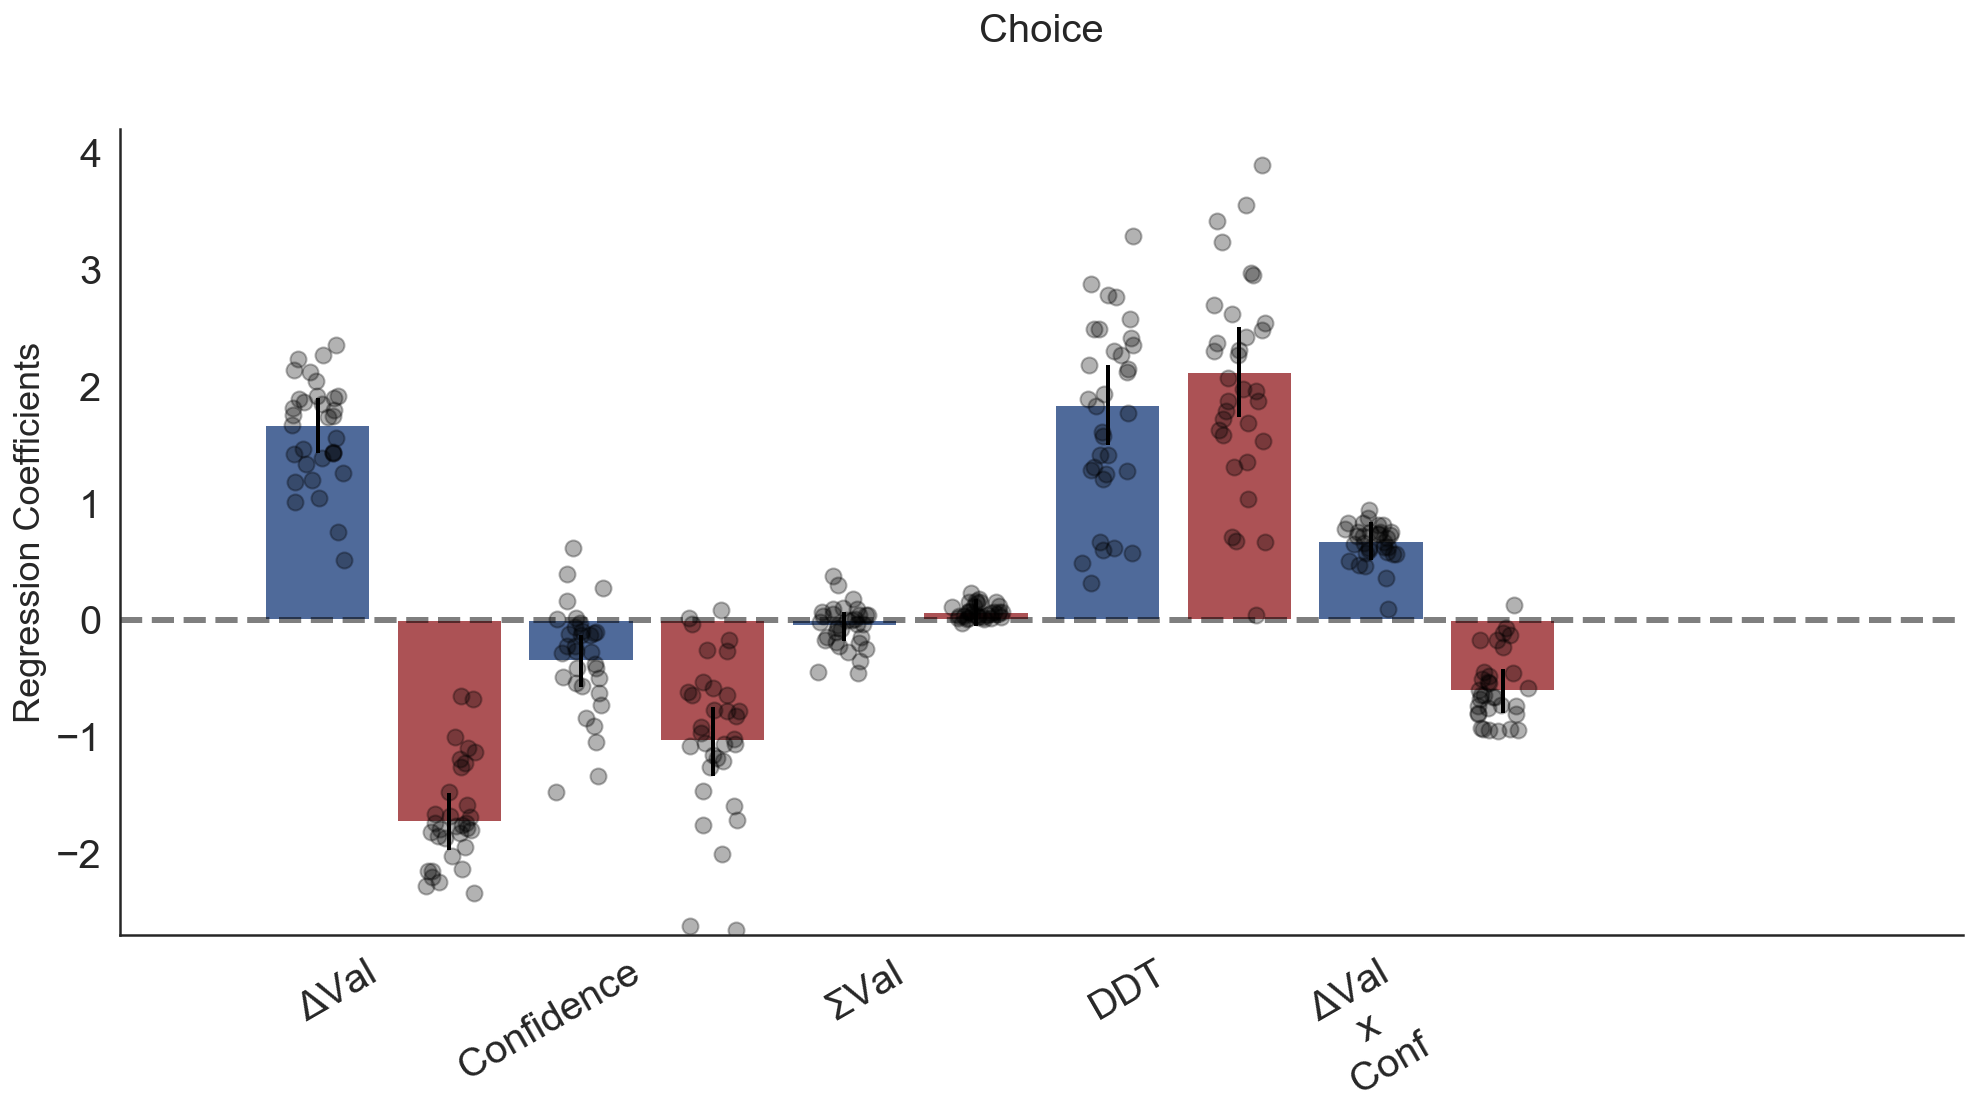

In [98]:
Coefpresplot_bar2(Choice_Like_hmodel_table, mix_Choice_Like_model,Choice_Dislike_hmodel_table, mix_Choice_Dislike_model, barcol1='#4F6A9A',barcol2='#AC5255', title='Choice', size='big',ymultiple=1, ticklabsize=20)
#plt.savefig('SavedFigures/Choice_Regression_Model.svg', format='svg', dpi = 500 )

ttestprint (Choice_Like_hmodel_table,Choice_Like_hmodel_table, mix_Choice_Like_model,mix_Choice_Dislike_model )



### Save the results of the model

In [74]:
%%R
save(Choice_Like_hmodel, file = "SavedModels/Models_33Part/HModel_Choice_Like_33_m1.rda")
save(Choice_Dislike_hmodel, file = "SavedModels/Models_33Part/HModel_Choice_Dislike_33_m1.rda")

## Confidence ~ BehavioralParams + GSF

### Dislike condition model

In [15]:
%%R
# Fit the multilevel linear model
if (file.exists('SavedModels/Models_33Part/HModel_Confidence_Dislike_33_m1.rda')){
    load('SavedModels/Models_33Part/HModel_Confidence_Dislike_33_m1.rda')   
    print('  Found old parameter estimates in "SavedModels/". Skipping estimation...')
}
else{
    confidence_Dislike_hmodel <- lmer(zConf ~  zAbsDVal +zRT +  zTotVal + zGSF + ( zAbsDVal + zRT  + zTotVal + zGSF| Part), data=data_exp1_DisLike, control=lmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
    display (confidence_Dislike_hmodel)
}

[1] "  Found old parameter estimates in \"SavedModels/\". Skipping estimation..."


In [16]:
%%R

# Extract mixed effect paramters
mix_Confidence_Dislike_model <- coef(confidence_Dislike_hmodel)

## Estimating DFs and p-values
# get the coefficients for the best fitting model
coefs <- data.frame(coef(summary(confidence_Dislike_hmodel)))
coefs
# Use the Kenward-Roger approximation to get approximate degrees of freedom
df.KR <- get_ddf_Lb(confidence_Dislike_hmodel, fixef(confidence_Dislike_hmodel))
coefs$df.KR <-(rep(df.KR, each=4))

# Calculate confidence intervals from the estimates and the standard errors
coefs$semax <- coefs$Estimate + (coefs$Std..Error)
coefs$semin <- coefs$Estimate - (coefs$Std..Error)

# get p-values from the t-distribution using the t-values and approximated
# degrees of freedom
coefs$p.KR <- 2 * (1 - pt(abs(coefs$t.value), df.KR))

# use normal distribution to approximate p-value (tends to be anti-conservative with small sample sizes)
coefs$p.z <- 2 * (1 - pnorm(abs(coefs$t.value)))


Error in get_ddf_Lb(confidence_Dislike_hmodel, fixef(confidence_Dislike_hmodel)) : 
  could not find function "get_ddf_Lb"


In [17]:
%%R
coefs

              Estimate Std..Error   t.value
(Intercept) -0.1081973 0.01949008 -5.551405
zAbsDVal     0.1409382 0.01888871  7.461503
zRT         -0.1997186 0.03765669 -5.303667
zTotVal     -0.1699072 0.02301482 -7.382513
zGSF        -0.1288546 0.02792179 -4.614842


In [18]:
%%R
summary(confidence_Dislike_hmodel)

Linear mixed model fit by REML ['lmerMod']
Formula: zConf ~ zAbsDVal + zRT + zTotVal + zGSF + (zAbsDVal + zRT + zTotVal +  
    zGSF | Part)
   Data: data_exp1_DisLike
Control: lmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

REML criterion at convergence: 10846.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.1598 -0.6877  0.1023  0.7352  3.0157 

Random effects:
 Groups   Name        Variance Std.Dev. Corr                   
 Part     (Intercept) 0.004959 0.07042                         
          zAbsDVal    0.001797 0.04239  -1.00                  
          zRT         0.029854 0.17278   0.23 -0.23            
          zTotVal     0.007517 0.08670   0.12 -0.12 -0.03      
          zGSF        0.009898 0.09949   0.07 -0.07  0.85  0.46
 Residual             0.874762 0.93529                         
Number of obs: 3960, groups:  Part, 33

Fixed effects:
            Estimate Std. Error t value
(Intercept) -0.10820    0.01949  -5.551
zAbsDVal    

In [19]:
#%%R 
#coef(confidence_Dislike_hmodel)

In [20]:
%R -o coefs -o mix_Confidence_Dislike_model
# extract
mix_Confidence_Dislike_model = mix_Confidence_Dislike_model[0]

conf_table_exp1 = coefs
conf_table_exp1

#Generate table with paramters to later plot
conf_table_exp1.columns = ['coefficient', 'se', 't' ]
conf_table_exp1 = conf_table_exp1.iloc[:, 0:-1].copy(); conf_table_exp1.loc[:, 'SEmax'] = conf_table_exp1['coefficient'] + conf_table_exp1['se']*2
conf_table_exp1.loc[:, 'SEmin'] = conf_table_exp1['coefficient'] - conf_table_exp1['se']*2
conf_table_exp1 = conf_table_exp1.transpose()
conf_table_exp1.columns = [ '(inter)','|ΔVal|', 'RT', 'ΣVal','GSF']
#conf_table_exp1.loc['p'] = np.round(conf_table_exp1.loc['p'], 4)
conf_table_exp1 = conf_table_exp1[['(inter)','|ΔVal|', 'RT', 'ΣVal','GSF']]
conf_table_Dislike = conf_table_exp1

conf_table_Dislike

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


,(inter),|ΔVal|,RT,ΣVal,GSF
coefficient,-0.108197,0.140938,-0.199719,-0.169907,-0.128855
se,0.019490,0.018889,0.037657,0.023015,0.027922
SEmax,-0.069217,0.178716,-0.124405,-0.123878,-0.073011
SEmin,-0.147177,0.103161,-0.275032,-0.215937,-0.184698


### Like Condition

In [21]:
%%R
# Fit the multilevel linear model
if (file.exists('SavedModels/Models_33Part/HModel_Confidence_Like_33_m1.rda')){
    print('  Found old parameter estimates in "SavedModels". Skipping estimation...')
    load('SavedModels/Models_33Part/HModel_Confidence_Like_33_m1.rda')   
}
else{
confidence_Like_hmodel <- lmer(zConf ~  zAbsDVal +zRT +  zTotVal + zGSF + ( zAbsDVal + zRT  + zTotVal + zGSF| Part), data=data_exp1_Like, control=lmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
display (confidence_Like_hmodel)
}

[1] "  Found old parameter estimates in \"SavedModels\". Skipping estimation..."


In [22]:
%%R

# Extract mixed effect paramters
mix_Confidence_Like_model <- coef(confidence_Like_hmodel)

## Estimating DFs and p-values
# get the coefficients for the best fitting model
coefs <- data.frame(coef(summary(confidence_Like_hmodel)))
coefs
# Use the Kenward-Roger approximation to get approximate degrees of freedom
df.KR <- get_ddf_Lb(confidence_Like_hmodel, fixef(confidence_Like_hmodel))
coefs$df.KR <-(rep(df.KR, each=4))

# Calculate confidence intervals from the estimates and the standard errors
coefs$semax <- coefs$Estimate + (coefs$Std..Error)
coefs$semin <- coefs$Estimate - (coefs$Std..Error)

# get p-values from the t-distribution using the t-values and approximated
# degrees of freedom
coefs$p.KR <- 2 * (1 - pt(abs(coefs$t.value), df.KR))

# use normal distribution to approximate p-value (tends to be anti-conservative with small sample sizes)
coefs$p.z <- 2 * (1 - pnorm(abs(coefs$t.value)))


Error in get_ddf_Lb(confidence_Like_hmodel, fixef(confidence_Like_hmodel)) : 
  could not find function "get_ddf_Lb"


In [23]:
%%R
summary(confidence_Like_hmodel)

Linear mixed model fit by REML ['lmerMod']
Formula: zConf ~ zAbsDVal + zRT + zTotVal + zGSF + (zAbsDVal + zRT + zTotVal +  
    zGSF | Part)
   Data: data_exp1_Like
Control: lmerControl(optimizer = "optimx", optCtrl = list(method = "nlminb"))

REML criterion at convergence: 10265.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.8955 -0.5965  0.1027  0.6900  2.9734 

Random effects:
 Groups   Name        Variance Std.Dev. Corr                   
 Part     (Intercept) 0.006500 0.08062                         
          zAbsDVal    0.007990 0.08939  -0.15                  
          zRT         0.015195 0.12327   0.19 -0.66            
          zTotVal     0.001797 0.04239   0.87 -0.47  0.64      
          zGSF        0.016829 0.12973  -0.09  0.39 -0.34 -0.25
 Residual             0.755390 0.86913                         
Number of obs: 3960, groups:  Part, 33

Fixed effects:
            Estimate Std. Error t value
(Intercept)  0.09493    0.01986   4.780
zAbsDVal     0.

In [24]:
%%R
coefs

               Estimate Std..Error   t.value
(Intercept)  0.09493061 0.01985824  4.780414
zAbsDVal     0.07900740 0.02248759  3.513377
zRT         -0.22224976 0.02950461 -7.532714
zTotVal      0.03819068 0.01778824  2.146962
zGSF        -0.13167628 0.03015725 -4.366323


In [25]:
%R -o coefs -o mix_Confidence_Like_model

mix_Confidence_Like_model = mix_Confidence_Like_model[0]

conf_table_exp1 = coefs
conf_table_exp1

#Generate table with paramters to later plot
conf_table_exp1.columns = ['coefficient', 'se', 't' ]
conf_table_exp1 = conf_table_exp1.iloc[:, 0:-1].copy(); conf_table_exp1.loc[:, 'SEmax'] = conf_table_exp1['coefficient'] + conf_table_exp1['se']*2
conf_table_exp1.loc[:, 'SEmin'] = conf_table_exp1['coefficient'] - conf_table_exp1['se']*2
conf_table_exp1 = conf_table_exp1.transpose()
conf_table_exp1.columns = [ '(inter)','|ΔVal|', 'RT', 'ΣVal','GSF']
#conf_table_exp1.loc['p'] = np.round(conf_table_exp1.loc['p'], 4)
conf_table_exp1 = conf_table_exp1[['(inter)','|ΔVal|','RT', 'ΣVal','GSF']]
conf_table_Like = conf_table_exp1
conf_table_Like

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


,(inter),|ΔVal|,RT,ΣVal,GSF
coefficient,0.094931,0.079007,-0.222250,0.038191,-0.131676
se,0.019858,0.022488,0.029505,0.017788,0.030157
SEmax,0.134647,0.123983,-0.163241,0.073767,-0.071362
SEmin,0.055214,0.034032,-0.281259,0.002614,-0.191991


### Plotting both conditions

Mismatch
---------------- SIGNIFICANT FACTOR ----------------------
(inter) : MeanL = 0.09; t =  9.18 ; p-value =0.0**
(inter) : MeanD = -0.11; t =  -12.91 ; p-value =0.0**
|ΔVal| : MeanL = 0.08; t =  6.65 ; p-value =0.0**
|ΔVal| : MeanD = 0.14; t =  27.94 ; p-value =0.0**
RT : MeanL = -0.22; t =  -13.19 ; p-value =0.0**
RT : MeanD = -0.2; t =  -7.16 ; p-value =0.0**
ΣVal : MeanL = 0.04; t =  6.62 ; p-value =0.0**
ΣVal : MeanD = -0.17; t =  -15.71 ; p-value =0.0**
GSF : MeanL = -0.13; t =  -7.49 ; p-value =0.0**
GSF : MeanD = -0.13; t =  -8.1 ; p-value =0.0**
---------------- COMPARE [ LIKE - DISLIKE ] ----------------------
(inter) : MeanL = 0.09; MeanD = -0.11; [Like - Dislike] =  0.0; t =  11.19 ; p-value =0.0**
|ΔVal| : MeanL = 0.08; MeanD = 0.14; [Like - Dislike] =  -0.0; t =  -4.63 ; p-value =0.0**
RT : MeanL = -0.22; MeanD = -0.2; [Like - Dislike] =  -0.0; t =  -0.82 ; p-value =0.42
ΣVal : MeanL = 0.04; MeanD = -0.17; [Like - Dislike] =  0.0; t =  15.72 ; p-value =0.0**
GSF : Me

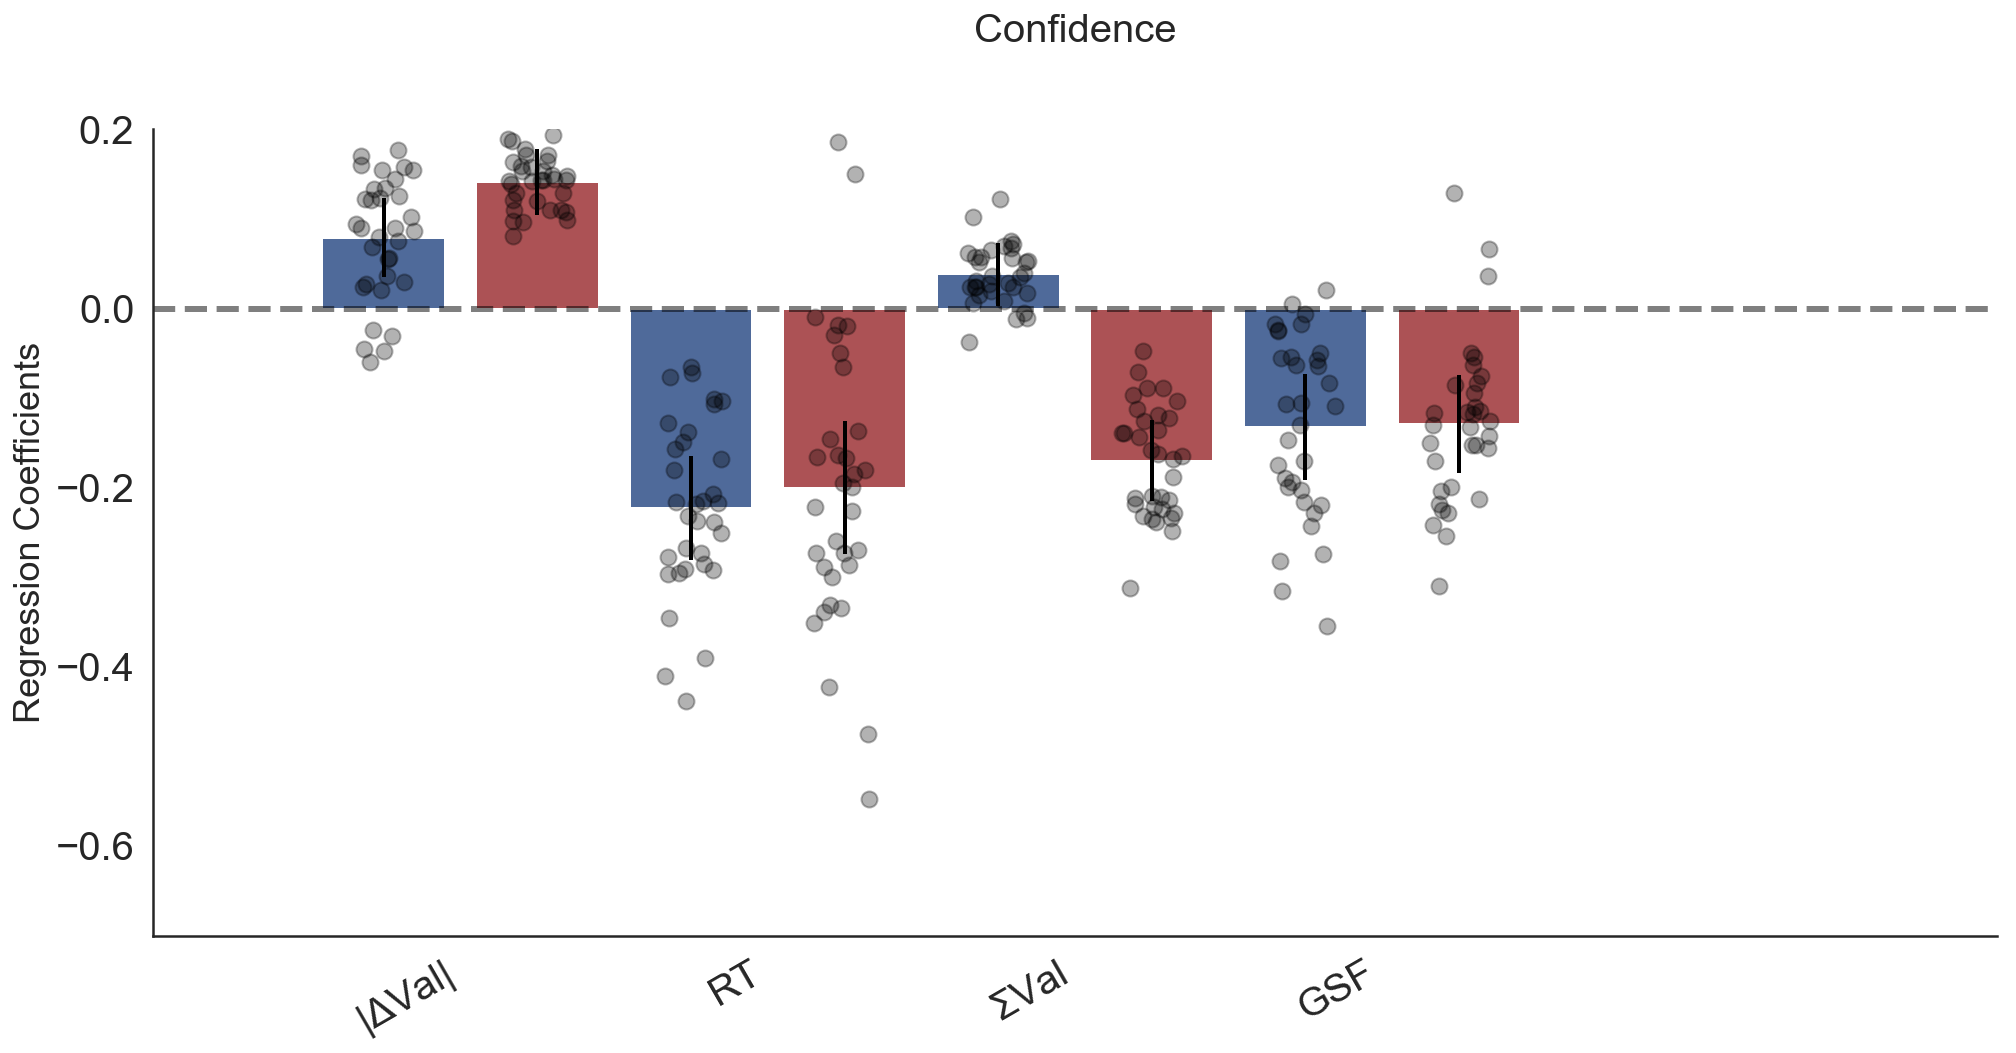

In [26]:
Coefpresplot_bar2(conf_table_Like, mix_Confidence_Like_model,conf_table_Dislike, mix_Confidence_Dislike_model, barcol1='#4F6A9A',barcol2='#AC5255', title='Confidence', size='big',ymultiple=0.2, ticklabsize=20)
ttestprint (conf_table_Like,conf_table_Dislike, mix_Confidence_Like_model,mix_Confidence_Dislike_model )

### Save the results of the model

In [84]:
%%R
save(confidence_Like_hmodel, file = "SavedModels/Models_33Part/HModel_Confidence_Like_33_m1.rda")
save(confidence_Dislike_hmodel, file = "SavedModels/Models_33Part/HModel_Confidence_Dislike_33_m1.rda")